# Test Global Model Pipeline
Quick validation with a small subset before full training

In [1]:
import os
import time
import joblib
import warnings
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Configuration

In [2]:
# Database
DB_CONFIG = {
    'host': 'localhost',
    'port': 5432,
    'database': 'market_data',
    'user': 'mluser',
    'password': 'mlpassword'
}

# TEST MODE: Only use a few stocks
TEST_STOCKS = ['aapl', 'msft', 'googl', 'amzn', 'tsla']  # 5 stocks for testing

PREDICTION_HORIZON = 60  # 5 hours ahead (60 * 5min)

## Database Functions

In [3]:
def get_db_engine():
    connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    return create_engine(connection_string)

def load_stock_data(engine, ticker):
    query = f'SELECT date, open, high, low, close, volume FROM market."{ticker}" ORDER BY date'
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    return df

engine = get_db_engine()
print("Connected to database")

Connected to database


## Feature Engineering

In [4]:
def create_features(df, ticker_id):
    """
    Generate technical indicators and targets.
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    # Target: Future Return
    df['target'] = df['close'].shift(-PREDICTION_HORIZON) / df['close'] - 1
    
    # Returns
    for lag in [1, 5, 10, 20]:
        df[f'ret_{lag}'] = df['close'].pct_change(lag)
    
    # Moving Averages
    for window in [10, 50]:
        df[f'sma_{window}'] = df['close'].rolling(window=window).mean()
        df[f'dist_sma_{window}'] = df['close'] / df[f'sma_{window}'] - 1
        
    # Volatility
    df['volatility_20'] = df['ret_1'].rolling(window=20).std()
    
    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-8)
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # Volume
    df['vol_ma_20'] = df['volume'].rolling(window=20).mean()
    df['vol_ratio'] = df['volume'] / (df['vol_ma_20'] + 1)
    
    # Time Features
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    
    # Ticker ID
    df['ticker_id'] = ticker_id
    
    # Cleanup
    df = df.dropna().reset_index(drop=True)
    
    # Downcast to float32
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    
    feature_cols = [
        'ticker_id', 'hour', 'dayofweek',
        'ret_1', 'ret_5', 'ret_10', 'ret_20',
        'dist_sma_10', 'dist_sma_50',
        'volatility_20', 'rsi', 'vol_ratio'
    ]
    
    return df[feature_cols], df['target'], df['date']

## Load Test Data (5 stocks)

In [5]:
# Label Encoder
le = LabelEncoder()
le.fit(TEST_STOCKS)

all_X = []
all_y = []
all_dates = []

for ticker in TEST_STOCKS:
    print(f"Loading {ticker}...")
    df_raw = load_stock_data(engine, ticker)
    print(f"  Raw rows: {len(df_raw)}")
    
    tid = le.transform([ticker])[0]
    X, y, dates = create_features(df_raw, tid)
    print(f"  After features: {len(X)} rows")
    
    all_X.append(X)
    all_y.append(y)
    all_dates.append(dates)

X_full = pd.concat(all_X, ignore_index=True)
y_full = pd.concat(all_y, ignore_index=True)
dates_full = pd.concat(all_dates, ignore_index=True)

print(f"\nTotal: {len(X_full)} rows")

Loading aapl...
  Raw rows: 215960
  After features: 215851 rows
Loading msft...
  Raw rows: 200696
  After features: 200587 rows
Loading googl...
  Raw rows: 203337
  After features: 203228 rows
Loading amzn...
  Raw rows: 213422
  After features: 213313 rows
Loading tsla...
  Raw rows: 221596
  After features: 221487 rows

Total: 1054466 rows


## Inspect Data

In [6]:
print("Features:")
print(X_full.columns.tolist())
print(f"\nShape: {X_full.shape}")
print(f"\nFeature Stats:")
X_full.describe()

Features:
['ticker_id', 'hour', 'dayofweek', 'ret_1', 'ret_5', 'ret_10', 'ret_20', 'dist_sma_10', 'dist_sma_50', 'volatility_20', 'rsi', 'vol_ratio']

Shape: (1054466, 12)

Feature Stats:


,ticker_id,hour,dayofweek,ret_1,ret_5,ret_10,ret_20,dist_sma_10,dist_sma_50,volatility_20,rsi,vol_ratio
count,1.054466e+06,1.054466e+06,1.054466e+06,1.054466e+06,1.054466e+06,1.054466e+06,1.054466e+06,1.054466e+06,1.054466e+06,1.054466e+06,1.054466e+06,1.054466e+06
mean,1.998621e+00,1.160524e+01,2.016735e+00,3.152671e-06,1.561731e-05,3.115497e-05,6.221569e-05,1.157740e-05,6.409695e-05,8.670279e-04,5.059201e+01,1.094686e+00
std,1.432311e+00,4.497265e+00,1.403387e+00,1.246303e-03,2.731799e-03,3.838114e-03,5.403397e-03,2.053584e-03,4.867945e-03,8.980732e-04,2.262633e+01,1.437015e+00
min,0.000000e+00,4.000000e+00,0.000000e+00,-7.613276e-02,-8.007449e-02,-7.849634e-02,-8.002713e-02,-7.006779e-02,-7.437734e-02,1.714326e-05,0.000000e+00,0.000000e+00
25%,1.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00,-7.702742e-04,-1.107612e-03,-1.616080e-03,-5.708567e-04,-1.462425e-03,3.814913e-04,3.423423e+01,5.014749e-01
50%,2.000000e+00,1.200000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.120852e-05,1.269817e-05,7.672569e-05,6.244027e-04,5.039999e+01,8.277851e-01
75%,3.000000e+00,1.500000e+01,3.000000e+00,0.000000e+00,8.104162e-04,1.187014e-03,1.783831e-03,6.077839e-04,1.659447e-03,1.039333e-03,6.697246e+01,1.209476e+00
max,4.000000e+00,1.900000e+01,4.000000e+00,1.184464e-01,1.408794e-01,1.426371e-01,1.597872e-01,1.059353e-01,1.331214e-01,2.714353e-02,1.000000e+02,1.999998e+01


Target (future returns) Stats:
  Mean:  0.0187%
  Std:   0.9403%
  Min:   -9.8736%
  Max:   15.7710%


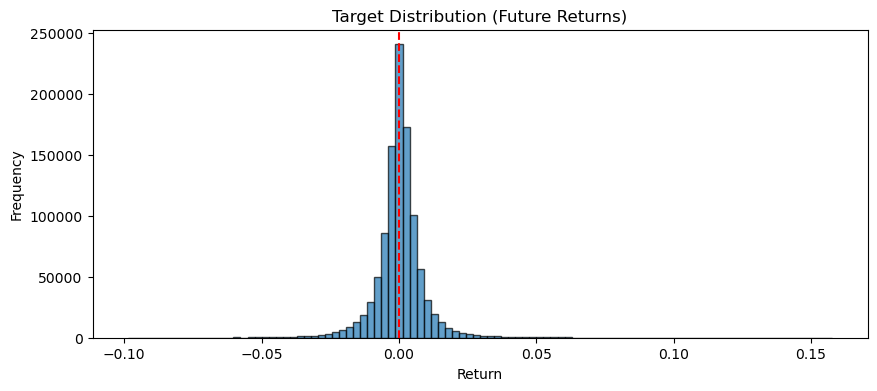

In [7]:
print("Target (future returns) Stats:")
print(f"  Mean:  {y_full.mean()*100:.4f}%")
print(f"  Std:   {y_full.std()*100:.4f}%")
print(f"  Min:   {y_full.min()*100:.4f}%")
print(f"  Max:   {y_full.max()*100:.4f}%")

plt.figure(figsize=(10, 4))
plt.hist(y_full, bins=100, edgecolor='black', alpha=0.7)
plt.title('Target Distribution (Future Returns)')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

## Train/Test Split

In [8]:
split_date = dates_full.quantile(0.8)
print(f"Split date: {split_date}")

mask_train = dates_full <= split_date
mask_test = dates_full > split_date

X_train = X_full[mask_train]
y_train = y_full[mask_train]
X_test = X_full[mask_test]
y_test = y_full[mask_test]

print(f"Train: {len(X_train)} rows")
print(f"Test:  {len(X_test)} rows")

Split date: 2025-05-15 07:20:00
Train: 843581 rows
Test:  210885 rows


## Train Model (Quick Test)

In [9]:
# Smaller model for quick testing
model = XGBRegressor(
    n_estimators=100,  # Reduced for testing
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    tree_method='hist',
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=10
)

print("Training...")
start = time.time()
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=20
)
print(f"\nTraining time: {time.time()-start:.1f}s")

Training...
[0]	validation_0-rmse:0.00815
[15]	validation_0-rmse:0.00816

Training time: 3.2s


## Evaluate

In [10]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("=" * 40)
print("TEST RESULTS")
print("=" * 40)
print(f"RMSE: {rmse:.6f} ({rmse*100:.4f}%)")
print(f"MAE:  {mae:.6f} ({mae*100:.4f}%)")

TEST RESULTS
RMSE: 0.008139 (0.8139%)
MAE:  0.004893 (0.4893%)


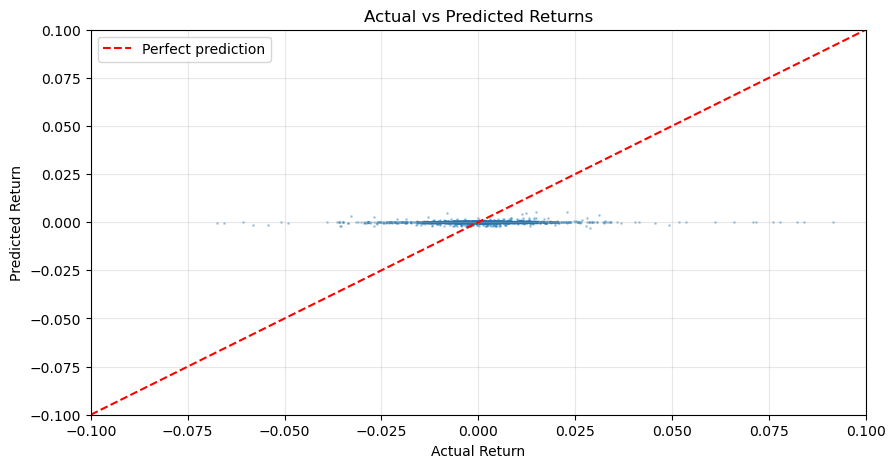

In [11]:
# Actual vs Predicted scatter
plt.figure(figsize=(10, 5))

# Sample for plotting (too many points)
sample_idx = np.random.choice(len(y_test), size=min(5000, len(y_test)), replace=False)

plt.scatter(y_test.iloc[sample_idx], y_pred[sample_idx], alpha=0.3, s=1)
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--', label='Perfect prediction')
plt.xlabel('Actual Return')
plt.ylabel('Predicted Return')
plt.title('Actual vs Predicted Returns')
plt.legend()
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.grid(True, alpha=0.3)
plt.show()

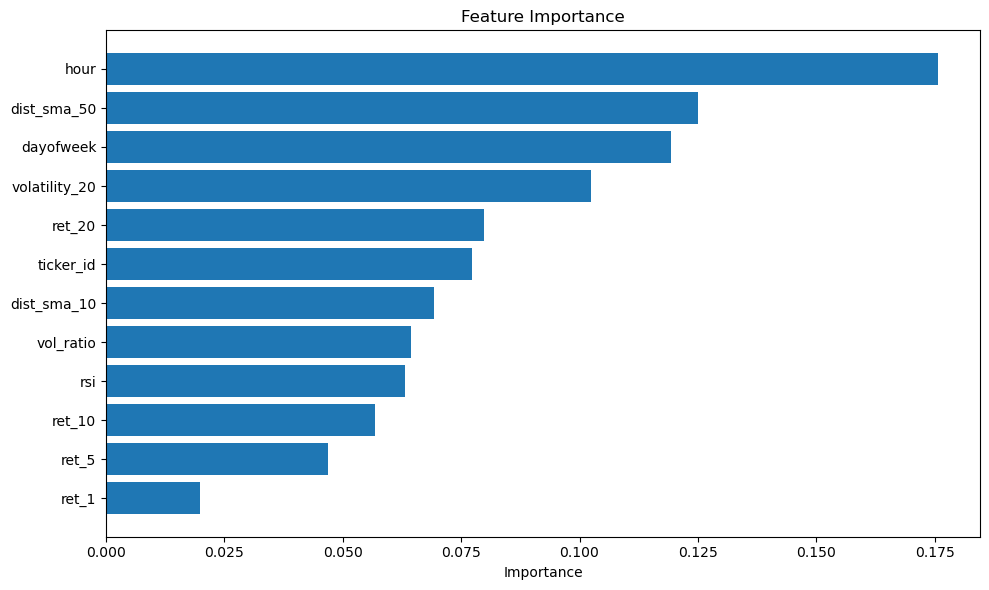

In [12]:
# Feature Importance
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## Direction Accuracy
How often does the model predict the correct direction (up/down)?

In [13]:
# Direction accuracy
actual_direction = (y_test > 0).astype(int)
pred_direction = (y_pred > 0).astype(int)

direction_accuracy = (actual_direction == pred_direction).mean()
print(f"Direction Accuracy: {direction_accuracy*100:.2f}%")
print(f"(Random baseline: 50%)")

Direction Accuracy: 52.29%
(Random baseline: 50%)


## Conclusion

If results look reasonable, run the full training script:
```bash
conda activate cosc471
python scripts/train_global_model.py
```